# Image Classification With Transfer Learning Using Keras

# Task 1: Importing Libraries

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.17.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# Task 2: Cats vs Dogs Dataset

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pets.download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz


In [3]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples:', count_train)
print('Test examples:', count_test)

Training examples: 3680
Test examples: 3669


In [4]:
test_annot

{'Abyssinian_201.jpg': 'cat',
 'Abyssinian_202.jpg': 'cat',
 'Abyssinian_204.jpg': 'cat',
 'Abyssinian_205.jpg': 'cat',
 'Abyssinian_206.jpg': 'cat',
 'Abyssinian_207.jpg': 'cat',
 'Abyssinian_20.jpg': 'cat',
 'Abyssinian_210.jpg': 'cat',
 'Abyssinian_212.jpg': 'cat',
 'Abyssinian_213.jpg': 'cat',
 'Abyssinian_215.jpg': 'cat',
 'Abyssinian_216.jpg': 'cat',
 'Abyssinian_217.jpg': 'cat',
 'Abyssinian_219.jpg': 'cat',
 'Abyssinian_21.jpg': 'cat',
 'Abyssinian_220.jpg': 'cat',
 'Abyssinian_221.jpg': 'cat',
 'Abyssinian_223.jpg': 'cat',
 'Abyssinian_224.jpg': 'cat',
 'Abyssinian_225.jpg': 'cat',
 'Abyssinian_226.jpg': 'cat',
 'Abyssinian_228.jpg': 'cat',
 'Abyssinian_22.jpg': 'cat',
 'Abyssinian_230.jpg': 'cat',
 'Abyssinian_232.jpg': 'cat',
 'Abyssinian_24.jpg': 'cat',
 'Abyssinian_25.jpg': 'cat',
 'Abyssinian_26.jpg': 'cat',
 'Abyssinian_27.jpg': 'cat',
 'Abyssinian_29.jpg': 'cat',
 'Abyssinian_2.jpg': 'cat',
 'Abyssinian_30.jpg': 'cat',
 'Abyssinian_31.jpg': 'cat',
 'Abyssinian_32.jpg': 

# Task 3: Get Random Batch

In [5]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    
    indices = np.random.choice(range(total_examples), batch_size)
    
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    
    for i, index in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[index])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
        
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis=0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[index]]]
        images.append(image)
    
    return x, y, images
    

Displaying first 8 examples..


<module 'matplotlib.pyplot' from '/Users/lukaswoodtli/Development/neural-nets/classification-with-transfer-learning/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

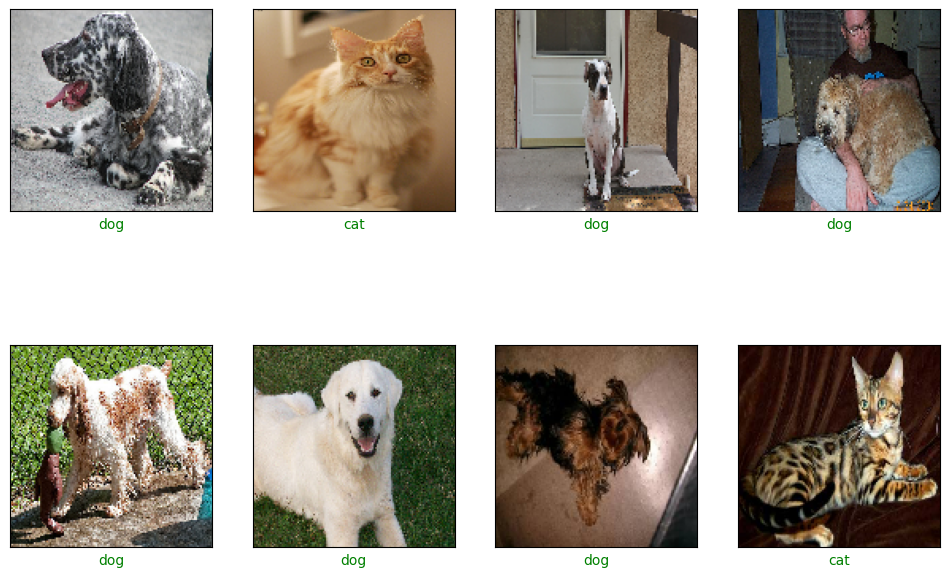

In [6]:
x, y, images = get_random_batch(train_annot, batch_size=8)
pets.display_examples(x, y, y, images, index_to_class)

# Task 4: Create Model

In [7]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3))
mnet.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [8]:
def create_model():
    model = tf.keras.models.Sequential(
        [
            mnet,
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ]
    )
    # transfer-learning: not training the pretrained layers
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Task 5: Model Training

In [9]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield x, y

In [10]:
batch_size = 32
steps_per_epoch = count_train // batch_size
validation_steps = count_test // batch_size

print('Training steps:', steps_per_epoch)
print('Validation steps:', validation_steps)

Training steps: 115
Validation steps: 114


In [11]:
%%time

_ = model.fit(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1  # low, because we use pretrained network
)

115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.7510 - loss: 0.5189 - val_accuracy: 0.9698 - val_loss: 0.1181
CPU times: user 1min 8s, sys: 16.2 s, total: 1min 25s
Wall time: 16.5 s


# Task 6: Predictions

In [12]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Displaying first 8 examples..


<module 'matplotlib.pyplot' from '/Users/lukaswoodtli/Development/neural-nets/classification-with-transfer-learning/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

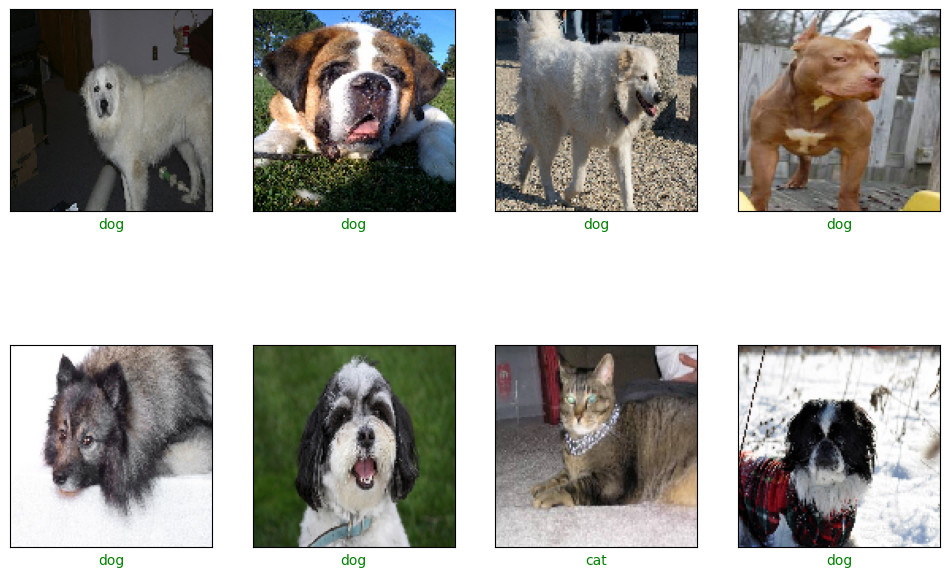

In [13]:
pets.display_examples(x, y, preds, images, index_to_class)